<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/FinetuningSenzaClassiRandom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#import sys
#sys.path.insert(0,"/content/drive/MyDrive/OWR-project/Project_MLDL")

Classification Network (using Resnet32) on CIFAR100

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms

### Data Load

In [2]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)
# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Build the model

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data
        self.fc = nn.Linear(in_features, out_features + num_new_outputs)
        self.fc.weight.data[:out_features] = weight
        #print(self.fc.out_features)

def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [4]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### Define the loss and the optimization technique

In [5]:
lr = 0.01
decay = 0.0001
epochs = 70
momentum = 0.9
factor = 5

In [6]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### NON INCREMENTAL

In [7]:
#train the network
for epoch in range(10):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):

    # get the inputs; data is a list of  [input,labels]
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor to zero.

    outputs = net.forward(inputs) # forward: assign weights to each edge in each layer
    loss = criterion(outputs,labels) # calculate the loss 
    loss.backward() # redesign the weights evaluating the performance of the network
    optimizer.step() # update parameters 

    running_loss += loss.item()
    if i % 100 == 99:    # print every 100 mini-batches the average value of the loss accumulated in each batch
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
      running_loss = 0.0

[1,   100] loss: 4.522
[1,   200] loss: 4.186
[1,   300] loss: 3.936
[2,   100] loss: 3.657
[2,   200] loss: 3.563
[2,   300] loss: 3.483
[3,   100] loss: 3.300
[3,   200] loss: 3.231
[3,   300] loss: 3.168
[4,   100] loss: 2.971
[4,   200] loss: 2.936
[4,   300] loss: 2.892
[5,   100] loss: 2.720
[5,   200] loss: 2.672
[5,   300] loss: 2.660
[6,   100] loss: 2.509
[6,   200] loss: 2.476
[6,   300] loss: 2.445
[7,   100] loss: 2.299
[7,   200] loss: 2.308
[7,   300] loss: 2.302
[8,   100] loss: 2.155
[8,   200] loss: 2.178
[8,   300] loss: 2.159
[9,   100] loss: 1.999
[9,   200] loss: 2.023
[9,   300] loss: 2.040
[10,   100] loss: 1.879
[10,   200] loss: 1.922
[10,   300] loss: 1.915


Accuracy of the network on the 10000 test images: 40 %


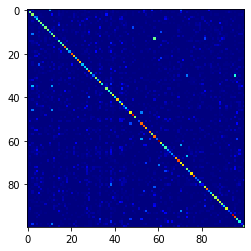

In [9]:
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


###INCREMENTAL

#### training function

In [10]:
# Each time we call training function we must pass a different trainloader, updated with the following 10 classes
def training(trainloader, iteration, network, device, epochs, num_classes):
  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)
  
  optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

  #train the network
  for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of  [input,labels]

      inputs = data[0].to(device)
      labels = data[1].to(device)
      optimizer.zero_grad() # Sets the gradients of all optimized torch.Tensor to zero.

      outputs = network.forward(inputs) # forward: assign weights to each edge in each layer
      loss = criterion(outputs,labels) # calculate the loss 
      loss.backward() # redesign the weights evaluating the performance of the network
      optimizer.step() # update parameters 

      running_loss += loss.item()
      if i % 20 == 19:    # print every 20 mini-batches the average value of the loss accumulated in each batch
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

####test function

In [11]:
def test(testloader, iteration, network, acc):
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  # if(iteration == 9):
  #   confusion_matrix = torch.zeros(100,100)
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          
          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

#### train execution

In [12]:
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration

  # train loader contains at each iteration the new 10 classes used to evaluate the network, while valid loader contains all classes seen so far

[1,    20] loss: 0.899
[1,    40] loss: 0.587
[2,    20] loss: 0.494
[2,    40] loss: 0.441
[3,    20] loss: 0.322
[3,    40] loss: 0.284
[4,    20] loss: 0.170
[4,    40] loss: 0.161
[5,    20] loss: 0.121
[5,    40] loss: 0.157
[6,    20] loss: 0.199
[6,    40] loss: 0.165
[7,    20] loss: 0.258
[7,    40] loss: 0.187
[8,    20] loss: 0.098
[8,    40] loss: 0.073
[9,    20] loss: 0.055
[9,    40] loss: 0.066
[10,    20] loss: 0.115
[10,    40] loss: 0.088
[11,    20] loss: 0.113
[11,    40] loss: 0.089
[12,    20] loss: 0.039
[12,    40] loss: 0.039
[13,    20] loss: 0.129
[13,    40] loss: 0.067
[14,    20] loss: 0.028
[14,    40] loss: 0.025
[15,    20] loss: 0.012
[15,    40] loss: 0.009
[16,    20] loss: 0.007
[16,    40] loss: 0.008
[17,    20] loss: 0.004
[17,    40] loss: 0.022
[18,    20] loss: 0.149
[18,    40] loss: 0.128
[19,    20] loss: 0.109
[19,    40] loss: 0.110
[20,    20] loss: 0.269
[20,    40] loss: 0.206
[21,    20] loss: 0.226
[21,    40] loss: 0.152
[22,    20

#### confusion matrix


Accuracy of the network on the 10000 test images: 9 %


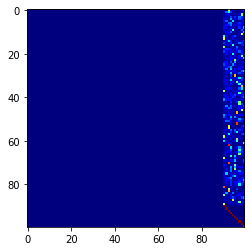

In [16]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))